In [1]:
file = 'data/bipartite/airport/train.in'
N = 5

# Cross Validation

In [1]:
import cross_validation

file = 'data/bipartite/crime/train.in'
N = 5
cross_validation.cross_validation(file, N, 5, bipartite=True)

NMF-10 : 0.47 (+/- 0.05)
svds-30 : 0.58 (+/- 0.10)
PA : 0.39 (+/- 0.04)
CN : 0.50 (+/- 0.00)
Adamic-Adar : 0.50 (+/- 0.00)
NMF-30 : 0.54 (+/- 0.05)
svds-10 : 0.56 (+/- 0.09)
sfdp-bipartite : 0.31 (+/- 0.00)
sfdp-default : 0.59 (+/- 0.09)


In [2]:
import cross_validation

file = 'data/bipartite/movielens/train.in'
N = 30
cross_validation.cross_validation(file, N, 1, bipartite=True)

NMF-10 : 0.92 (+/- 0.00)
svds-30 : 0.94 (+/- 0.00)
PA : 0.90 (+/- 0.00)
CN : 0.50 (+/- 0.00)
Adamic-Adar : 0.50 (+/- 0.00)
NMF-30 : 0.94 (+/- 0.00)
svds-10 : 0.93 (+/- 0.00)
sfdp-bipartite : 0.89 (+/- 0.00)
sfdp-default : 0.84 (+/- 0.00)


In [3]:
file = 'data/bipartite/frwikinews/train.in'
N = 30
cross_validation.cross_validation(file, N, 1, bipartite=True, gap=0)

NMF-10 : 0.72 (+/- 0.00)
svds-30 : 0.61 (+/- 0.00)
PA : 0.82 (+/- 0.00)
CN : 0.50 (+/- 0.00)
Adamic-Adar : 0.50 (+/- 0.00)
NMF-30 : 0.60 (+/- 0.00)
svds-10 : 0.75 (+/- 0.00)
sfdp-bipartite : 0.81 (+/- 0.00)
sfdp-default : 0.74 (+/- 0.00)


In [4]:
import cross_validation
file = 'data/bipartite/condmat/train.in'
N = 30
cross_validation.cross_validation(file, N, 1, bipartite=True, gap=0)

NMF-10 : 0.59 (+/- 0.00)
svds-30 : 0.64 (+/- 0.00)
PA : 0.57 (+/- 0.00)
CN : 0.50 (+/- 0.00)
Adamic-Adar : 0.50 (+/- 0.00)
NMF-30 : 0.61 (+/- 0.00)
svds-10 : 0.59 (+/- 0.00)
sfdp-bipartite : 0.60 (+/- 0.00)
sfdp-default : 0.70 (+/- 0.00)


# Basic Workflow

In [53]:
import tools

In [54]:
train_set, nodes, poss_set, neg_set = tools.sample_bipartite(file, 0)

IOError: [Errno 2] No such file or directory: 'data/bipartite/airport/train.in'

# Choose poss set with less components increasing

In [5]:
from graph_tool.all import *
g = Graph(directed=False)
g.add_vertex(max(nodes) + 1)
for edge in train_set:
    u, w = map(int, edge.split())
    g.add_edge(g.vertex(u), g.vertex(w))

In [ ]:
train_set_2 = set()
for edge in train_set:
    u, w = map(int, edge.split())
    if g.vertex(u).out_degree() > 1 and g.vertex(w).out_degree() > 1:
        train_set_2.add(edge)

In [48]:
len(train_set_2)

724

In [49]:
poss_set = tools.sample_structural_poss(train_set_2, int(N * len(train_set) / 100.))

# Get coordinates

In [32]:
from graph_tool.all import *
g = Graph(directed=False)
g.add_vertex(max(nodes) + 1)

<generator object <genexpr> at 0x7f78e1e4d0f0>

In [33]:
a = 0
for edge in train_set:
    if edge not in poss_set:
        a += 1
        u, w = map(int, edge.split())
        g.add_edge(g.vertex(u), g.vertex(w))
print 1.0 * a / len(train_set)

1.0


In [34]:
is_bi, part = graph_tool.topology.is_bipartite(g, partition=True)

In [35]:
is_bi

True

In [36]:
groups = g.new_vertex_property("int")

In [37]:
for u in g.vertices():
    groups[u] = part[u]

In [45]:
pos_default = sfdp_layout(g, gamma=0)

In [46]:
pos = sfdp_layout(g, groups=groups, bipartite=True, verbose=True, gamma=0, bipartite_method=[
    "repulse-all", "repulse-all"])

Positioning level: 0 1381 with K = 19.1998421919 ...
avg edge distance: 33.4843371456


In [47]:
pos_bip = sfdp_layout(g, groups=groups, bipartite=True, verbose=True, gamma=0, bipartite_method=[
    "repulse-all", "repulse-aliens"])

Positioning level: 0 1381 with K = 19.2581716199 ...
avg edge distance: 34.2408688116


In [48]:
pos_bip

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7f78e0074e90, at 0x7f792c20c850>

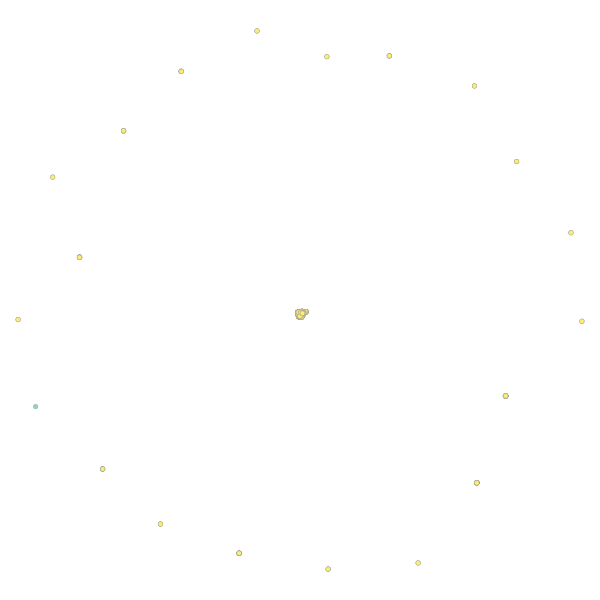

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7f78e0074e90, at 0x7f78e1e60d90>

In [49]:
%matplotlib inline

graph_draw(g, pos=pos_default, vertex_fill_color=groups)

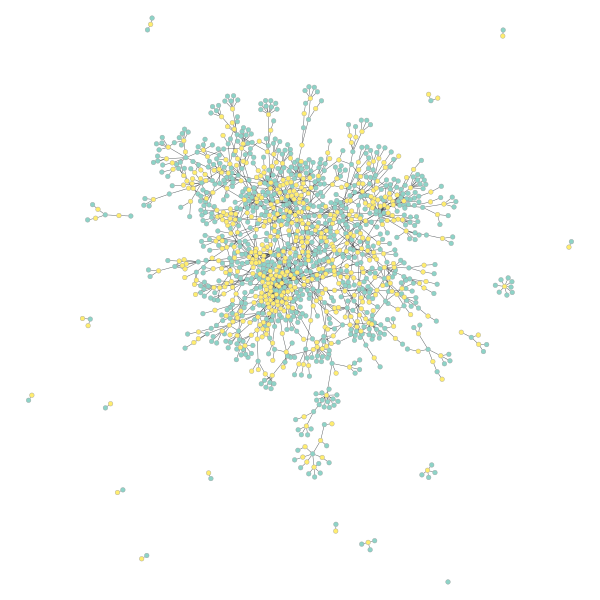

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7f78e0074e90, at 0x7f7929f02ad0>

In [50]:
%matplotlib inline

graph_draw(g, pos=pos, vertex_fill_color=groups)

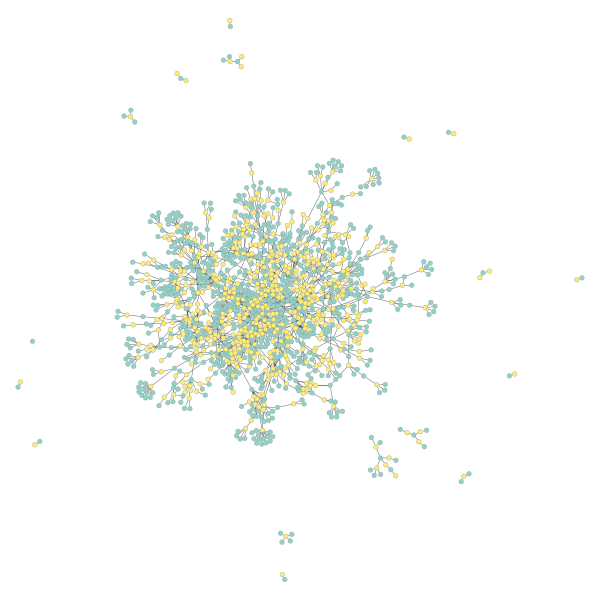

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7f78e0074e90, at 0x7f792c20c850>

In [51]:
%matplotlib inline

graph_draw(g, pos=pos_bip, vertex_fill_color=groups)

In [24]:
from sklearn.metrics import roc_auc_score

In [27]:
features = tools.TopologicalFeatures(g, pos, gap=0)
X, Y = tools.make_dataset(poss_set, neg_set, 
                    [features.dist])
print "sfdp default: ", roc_auc_score(Y, X)

sfdp default:  0.331018952899


In [26]:
features = tools.TopologicalFeatures(g, pos_bip, gap=0)
X, Y = tools.make_dataset(poss_set, neg_set, 
                    [features.dist])
print "sfdp bipartite simple: ", roc_auc_score(Y, X)

sfdp bipartite simple:  0.36892475136


In [17]:
features = tools.TopologicalFeatures(g, pos)
X, Y = tools.make_dataset(poss_set, neg_set, 
                    [features.dist])
print "sfdp default groups: ",roc_auc_score(Y, X)

NameError: name 'pos' is not defined

In [131]:
features = tools.TopologicalFeatures(g, pos_bip)
X, Y = tools.make_dataset(poss_set, neg_set, 
                    [features.preferential_attachment])
roc_auc_score(Y, X)

0.84588335250832158

In [132]:
from sklearn.decomposition import NMF
model = NMF(n_components=10, init='random', random_state=0)

matrix = tools.make_sparse_matrix(train_set, nodes, poss_set)

features = tools.MFFeatures(model, matrix)
X, Y = tools.make_dataset(poss_set, neg_set, 
                    [features.score])
roc_auc_score(Y, X)

0.7491702633011913

In [133]:
from scipy.sparse import linalg
import numpy

matrix = tools.make_sparse_matrix(train_set, nodes, poss_set)
U, s, Vh = linalg.svds(matrix.asfptype(), k=30)

def score(u, w):
    return numpy.dot(U[u] * s, Vh.T[w])

features = tools.MFFeatures(model, matrix)
X, Y = tools.make_dataset(poss_set, neg_set, 
                    [score])
roc_auc_score(Y, X)

0.69061234953990625